#  Brain Tumor Classification Notebook
This notebook performs brain tumor classification using:
-  Baseline CNN
-  Deeper CNN with regularization
-  Transfer Learning using VGG16

It also includes prediction visualization and performance evaluation.

In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2025-05-11 10:48:52.212095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746960532.468164      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746960532.545834      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


##  Dataset Setup

In [3]:
source_dir = '/kaggle/input/braintumor-ai/Brain Tumor'
target_dir = '/kaggle/working/Brain_Tumor'

if not os.path.exists(target_dir):
    shutil.copytree(source_dir, target_dir)
    print(" Dataset copied to writable directory.")

✅ Dataset copied to writable directory.


# Pre Processing

In [4]:
train_dir = os.path.join(target_dir, 'train')
test_dir = os.path.join(target_dir, 'test')

In [5]:
from PIL import UnidentifiedImageError, Image

def clean_corrupt_images(directory):
    total_checked = 0
    corrupt_files = 0
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if not os.path.isdir(folder_path):
            continue
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(file_path)
                img.verify()
                total_checked += 1
            except (IOError, SyntaxError, UnidentifiedImageError):
                print(f" Corrupt image removed: {file_path}")
                os.remove(file_path)
                corrupt_files += 1
    print(f"\n Checked {total_checked} files. Removed {corrupt_files} corrupt files.")

#  Apply cleaning to both training and test sets
clean_corrupt_images(os.path.join(target_dir, "train"))
clean_corrupt_images(os.path.join(target_dir, "test"))

❌ Corrupt image removed: /kaggle/working/Brain_Tumor/train/normal/N_132.jpg
❌ Corrupt image removed: /kaggle/working/Brain_Tumor/train/normal/N_66.jpg
❌ Corrupt image removed: /kaggle/working/Brain_Tumor/train/normal/N_166.jpg
❌ Corrupt image removed: /kaggle/working/Brain_Tumor/train/normal/N_90.jpg
❌ Corrupt image removed: /kaggle/working/Brain_Tumor/train/normal/N_278.jpg
❌ Corrupt image removed: /kaggle/working/Brain_Tumor/train/normal/N_263.jpg
❌ Corrupt image removed: /kaggle/working/Brain_Tumor/train/normal/N_276.jpg
❌ Corrupt image removed: /kaggle/working/Brain_Tumor/train/meningioma_tumor/M_154.jpg
❌ Corrupt image removed: /kaggle/working/Brain_Tumor/train/meningioma_tumor/M_765.jpg
❌ Corrupt image removed: /kaggle/working/Brain_Tumor/train/meningioma_tumor/M_323.jpg
❌ Corrupt image removed: /kaggle/working/Brain_Tumor/train/meningioma_tumor/M_680.jpg
❌ Corrupt image removed: /kaggle/working/Brain_Tumor/train/meningioma_tumor/M_54.jpg
❌ Corrupt image removed: /kaggle/working/

In [6]:
train_dir = os.path.join(target_dir, "train")
classes = os.listdir(train_dir)
print(" Classes found:", classes)

🔍 Classes found: ['normal', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor']


In [7]:
from PIL import Image

# Path to the image you want to check
img_path = '/kaggle/input/braintumor-ai/Brain Tumor/test/meningioma_tumor/M_107.jpg'

# print its dimensions
with Image.open(img_path) as img:
    width, height = img.size
   
    print(f" Original Size: {width} x {height} pixels")


 Original Size: 256 x 256 pixels


In [8]:
image_counts = {}
for cls in classes:
    class_path = os.path.join(train_dir, cls)
    count = len(os.listdir(class_path))
    image_counts[cls] = count
    print(f"{cls}: {count} images")

normal: 343 images
meningioma_tumor: 723 images
glioma_tumor: 713 images
pituitary_tumor: 668 images


In [9]:
for cls in classes:
    class_path = os.path.join(test_dir, cls)
    count = len(os.listdir(class_path))
    image_counts[cls] = count
    print(f"{cls}: {count} images")

normal: 88 images
meningioma_tumor: 183 images
glioma_tumor: 181 images
pituitary_tumor: 169 images


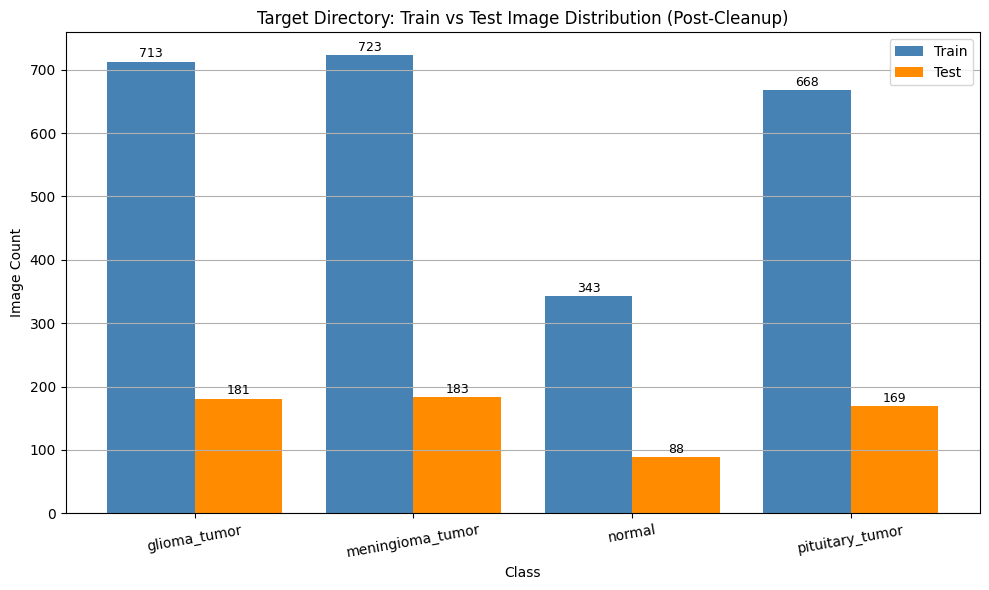

In [10]:
import os
import matplotlib.pyplot as plt

def plot_multivariate_bar_chart(train_dir, test_dir, title):
    train_counts = {}
    test_counts = {}

    for cls in os.listdir(train_dir):
        train_cls_path = os.path.join(train_dir, cls)
        train_counts[cls] = len(os.listdir(train_cls_path))

    for cls in os.listdir(test_dir):
        test_cls_path = os.path.join(test_dir, cls)
        test_counts[cls] = len(os.listdir(test_cls_path))

    classes = sorted(set(train_counts.keys()).union(test_counts.keys()))
    train_values = [train_counts.get(cls, 0) for cls in classes]
    test_values = [test_counts.get(cls, 0) for cls in classes]

    x = range(len(classes))
    bar_width = 0.4

    plt.figure(figsize=(10, 6))
    bars1 = plt.bar([i - bar_width/2 for i in x], train_values, width=bar_width, label='Train', color='steelblue')
    bars2 = plt.bar([i + bar_width/2 for i in x], test_values, width=bar_width, label='Test', color='darkorange')

    # Add count labels
    for bar in bars1 + bars2:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 2, str(yval), ha='center', va='bottom', fontsize=9)

    plt.xticks(ticks=x, labels=classes, rotation=10)
    plt.xlabel("Class")
    plt.ylabel("Image Count")
    plt.title(title)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()



#  Plot for target_dir
plot_multivariate_bar_chart(train_dir, test_dir, "Target Directory: Train vs Test Image Distribution (Post-Cleanup)")


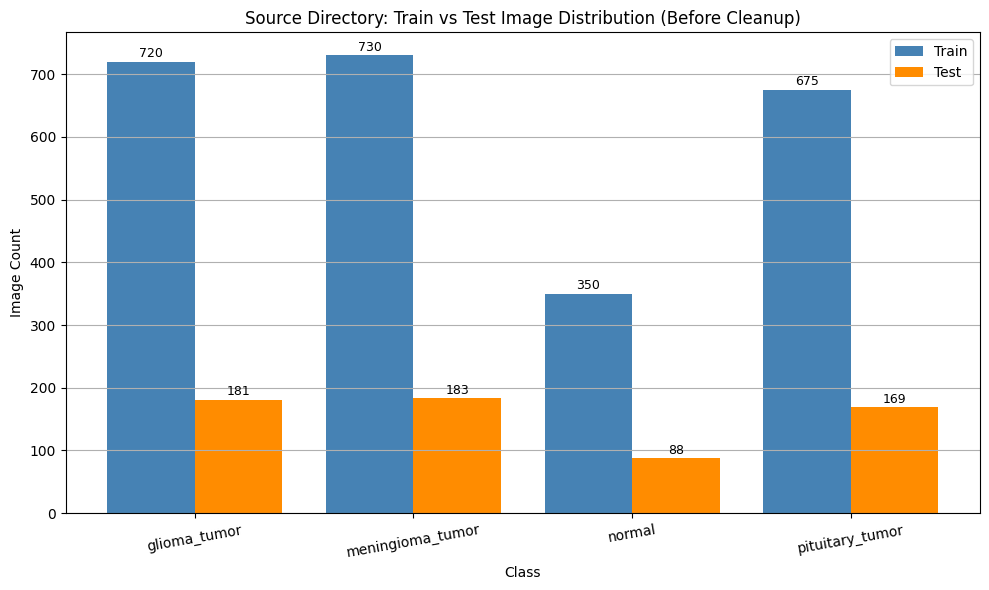

In [11]:
# Paths (replace with your actual Kaggle dataset path if different)
source_train_dir = os.path.join('/kaggle/input/braintumor-ai/Brain Tumor', 'train')
source_test_dir = os.path.join('/kaggle/input/braintumor-ai/Brain Tumor', 'test')

#  Plot for source_dir
plot_multivariate_bar_chart(source_train_dir, source_test_dir, "Source Directory: Train vs Test Image Distribution (Before Cleanup)")


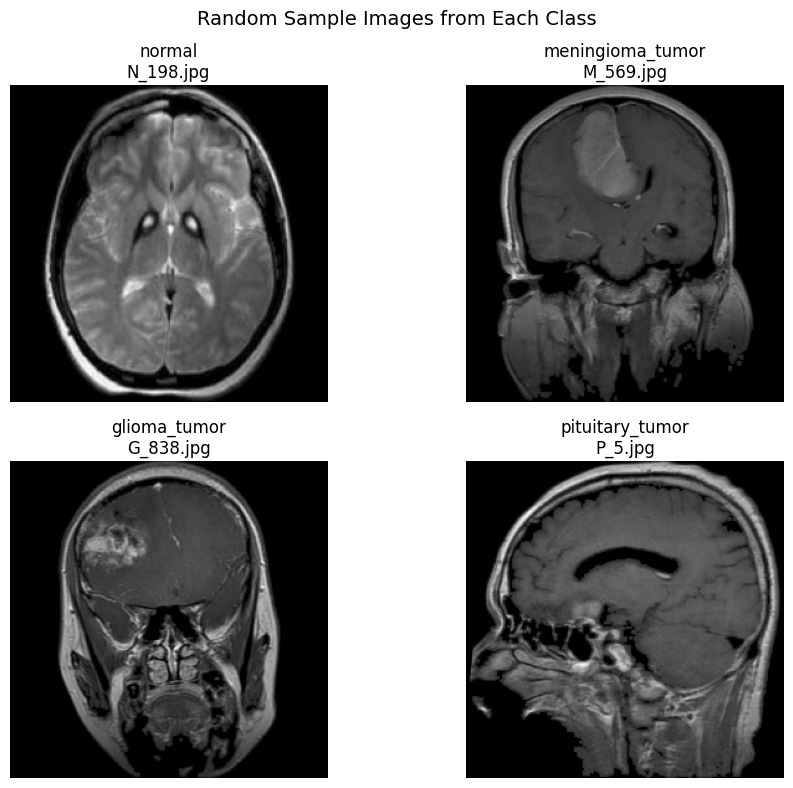

In [12]:
import random
#  Visualize a random sample image from each class
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows × 2 columns
for i, class_name in enumerate(classes[:4]):  # Limit to 4 classes
    class_path = os.path.join(train_dir, class_name)
    sample_image = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, sample_image)
    img = Image.open(img_path)

    row = i // 2
    col = i % 2

    axes[row, col].imshow(img)
    axes[row, col].set_title(f"{class_name}\n{sample_image}")
    axes[row, col].axis("off")

plt.suptitle("Random Sample Images from Each Class", fontsize=14)
plt.tight_layout()
plt.show()

##  Data Generators and Augmentation

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (150, 150)
batch_size = 32

# For training: augmentation + rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values from [0, 255] to [0, 1]
    rotation_range=20,           # Randomly rotate images by up to 20 degrees
    zoom_range=0.2,              # Randomly zoom images by up to 20%
    horizontal_flip=True,        # Randomly flip images horizontally
    width_shift_range=0.2,       # Shift images horizontally by up to 20% of width
    height_shift_range=0.2,      # Shift images vertically by up to 20% of height
    validation_split=0.2         # Reserve 20% of data for validation
)


# For validation: only rescaling
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training generator (with augmentation)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator (without augmentation)
val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 1960 images belonging to 4 classes.
Found 487 images belonging to 4 classes.


In [14]:
# For testing: rescaling
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,                    # Path to test directory
    target_size=img_size,        # Same size as train/val
    batch_size=1,                # Use batch size 1 for evaluation/prediction
    class_mode='categorical',    # Categorical labels
    shuffle=False                # Do not shuffle for consistent evaluation
)

Found 621 images belonging to 4 classes.


In [15]:
test_datagen_224 = ImageDataGenerator(rescale=1./255)

test_generator_224 = test_datagen_224.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 621 images belonging to 4 classes.


/tmp/ipykernel_31/3532734909.py:15: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


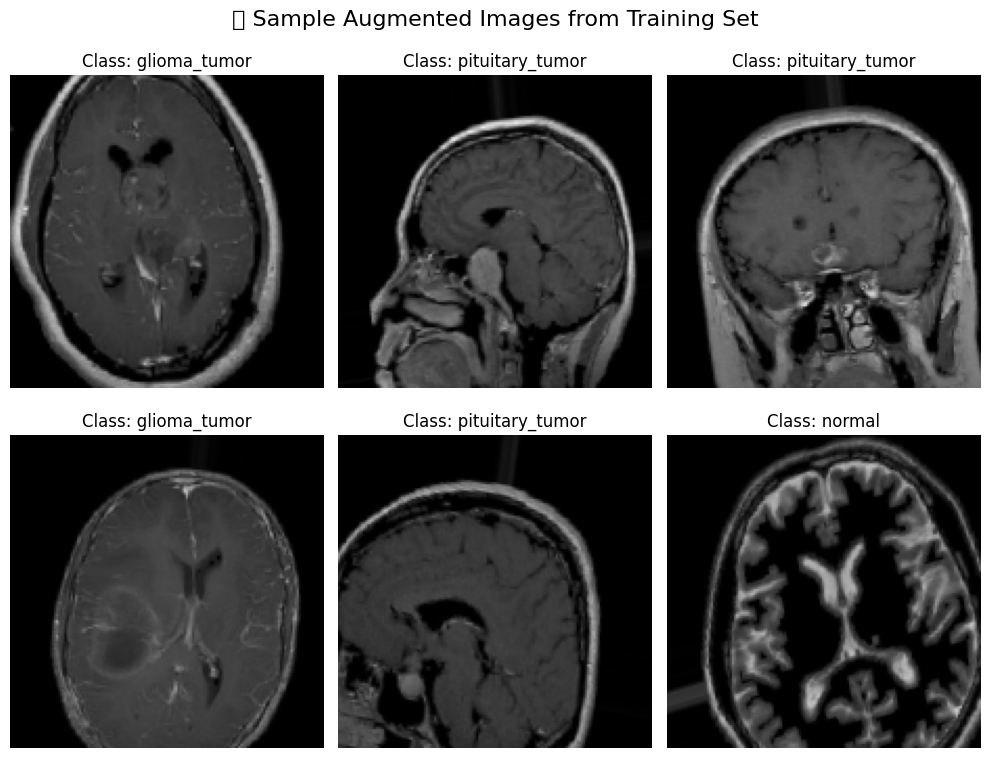

In [16]:
# Get one batch of augmented images and labels
augmented_images, augmented_labels = next(train_generator)

# Plot the first 6 augmented images
plt.figure(figsize=(10, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_images[i])
    class_index = np.argmax(augmented_labels[i])
    class_name = list(train_generator.class_indices.keys())[class_index]
    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.suptitle Sample Augmented Images from Training Set", fontsize=16)
plt.tight_layout()
plt.show()


##  Baseline CNN Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#  Define the model
def build_baseline_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [18]:
#  Build model

baseline_model = build_baseline_model((150, 150, 3), train_generator.num_classes)
baseline_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746960577.830129      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746960577.830946      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,838,820 (18.46 MB)

 Trainable params: 4,838,820 (18.46 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
import time


#  Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('baseline_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

#  Start timer
start_baseline = time.time()

#  Train the model
history_baseline = baseline_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


#  End timer
end_baseline = time.time()
print(f"⏱ Baseline model training time: {(end_baseline - start_baseline)/60:.2f} minutes")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746960584.004175     127 service.cc:148] XLA service 0x7a79fc006e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746960584.005298     127 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746960584.005325     127 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746960584.382270     127 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/62 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - accuracy: 0.2500 - loss: 1.3839

I0000 00:00:1746960588.188852     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.2848 - loss: 1.3769
Epoch 1: val_loss improved from inf to 1.34510, saving model to baseline_best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - accuracy: 0.2848 - loss: 1.3766 - val_accuracy: 0.2957 - val_loss: 1.3451
Epoch 2/50
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.3327 - loss: 1.3424
Epoch 2: val_loss improved from 1.34510 to 1.20009, saving model to baseline_best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step - accuracy: 0.3331 - loss: 1.3419 - val_accuracy: 0.5092 - val_loss: 1.2001
Epoch 3/50
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.4332 - loss: 1.2279
Epoch 3: val_loss improved from 1.20009 to 1.05580, saving model to baseline_best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 0.4332 - loss: 1.2274 - val_accuracy: 0.5113 - val_loss: 1.0558
Epoch 4/50
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5027 - loss: 1.1234
Epoch 4: val_loss did not improve f

In [20]:
import matplotlib.pyplot as plt

#  Plot training and validation accuracy and loss
def plot_baseline_history(history):
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Baseline Model - Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Baseline Model - Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



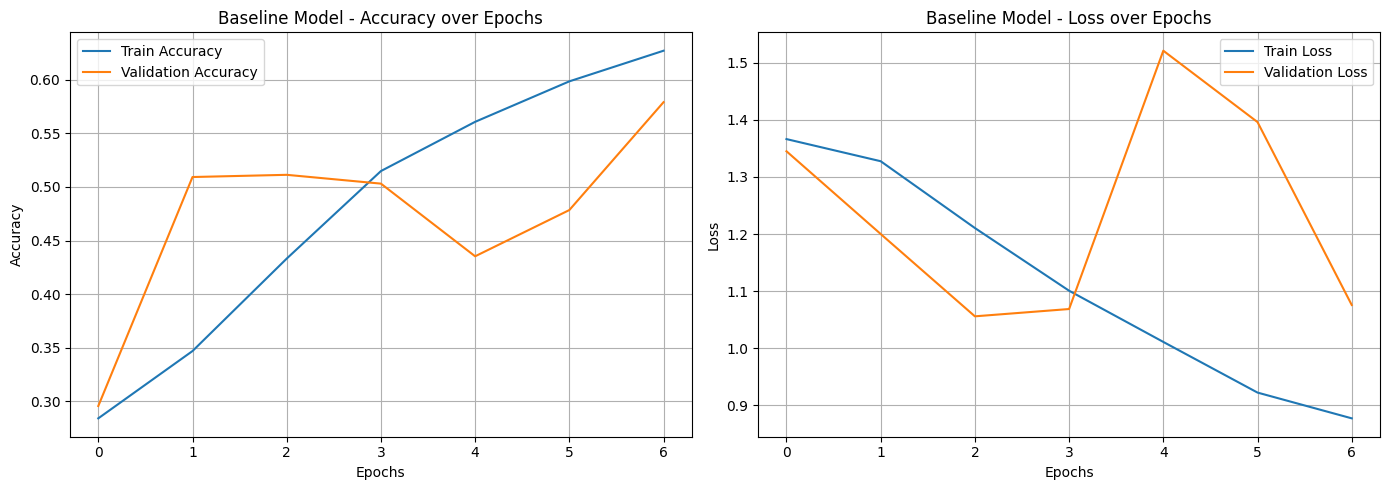

In [21]:
# Call the plot function
plot_baseline_history(history_baseline)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model_on_test(model, test_generator, model_name='Model'):
    # Ensure consistent predictions
    test_generator.reset()

    # Get predictions
    y_probs = model.predict(test_generator, verbose=1)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Classification report
    print(f"\n Classification Report - {model_name}:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


621/621 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

📋 Classification Report - Baseline CNN:
                  precision    recall  f1-score   support

    glioma_tumor       0.85      0.34      0.49       181
meningioma_tumor       0.44      0.55      0.49       183
          normal       0.50      0.58      0.54        88
 pituitary_tumor       0.60      0.76      0.67       169

        accuracy                           0.55       621
       macro avg       0.60      0.56      0.55       621
    weighted avg       0.61      0.55      0.55       621



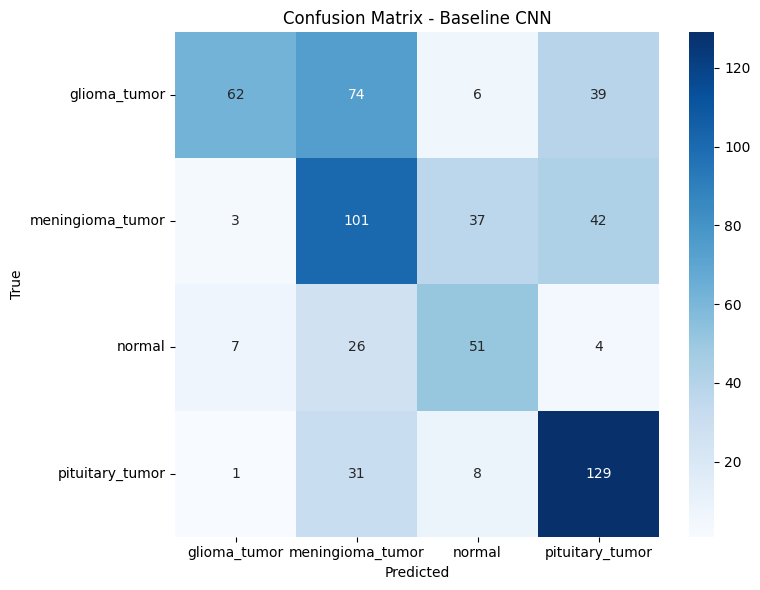

In [23]:
evaluate_model_on_test(baseline_model, test_generator, model_name='Baseline CNN')


In [24]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

def predict_and_display_image_for_model(
    model,
    model_name='Model',
    img_path='/kaggle/input/braintumor-ai/Brain Tumor/test/meningioma_tumor/M_107.jpg',
    class_labels=None,
    target_size=(150, 150)
):
    if class_labels is None:
        class_labels = list(test_generator.class_indices.keys())  # fallback if not provided

    # Load and preprocess image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Predict
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction[0])
    predicted_class = class_labels[predicted_class_index]
    true_class = os.path.basename(os.path.dirname(img_path))

    # Output
    print(f"\n Model        : {model_name}")
    print(f" Real class   : {true_class}")
    print(f" Predicted    : {predicted_class}")
    print("Prediction probabilities:")
    for i, prob in enumerate(prediction[0]):
        print(f"  {class_labels[i]}: {prob:.4f}")

    # Visual
    plt.imshow(img)
    plt.title(f"{model_name}\nActual: {true_class} | Predicted: {predicted_class}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step

 Model        : Baseline CNN
 Real class   : meningioma_tumor
 Predicted    : meningioma_tumor
Prediction probabilities:
  glioma_tumor: 0.1897
  meningioma_tumor: 0.4992
  normal: 0.1766
  pituitary_tumor: 0.1345


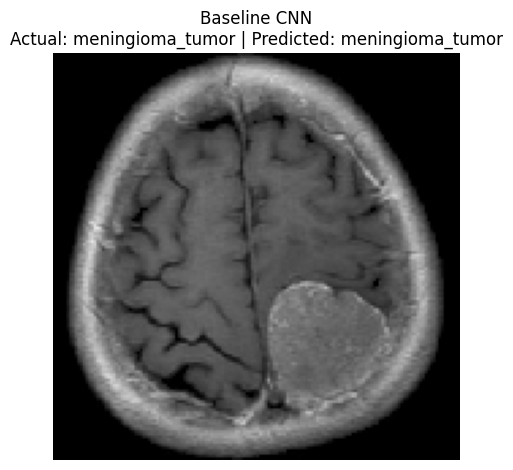

In [25]:
predict_and_display_image_for_model(
    model=baseline_model,
    model_name='Baseline CNN',
    target_size=(150, 150)
)


##  Deeper CNN Model with Regularization

In [ ]:
def build_deeper_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [27]:
# Build model
deeper_model_adam = build_deeper_model((150,150, 3), train_generator.num_classes)
deeper_model_adam.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,635,268 (13.87 MB)

 Trainable params: 3,634,308 (13.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [28]:
import time


#  Callbacks
checkpoint_adam = ModelCheckpoint('deeper_adam_best.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stop_adam = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)

#  Start timer
start_deeper = time.time()

#  Train the deeper model
history_deeper_adam = deeper_model_adam.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint_adam, early_stop_adam]
)

#  End timer
end_deeper = time.time()
print(f" Deeper model training time: {(end_deeper - start_deeper)/60:.2f} minutes")


Epoch 1/50
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.3126 - loss: 3.5483
Epoch 1: val_loss improved from inf to 1.78055, saving model to deeper_adam_best.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 251ms/step - accuracy: 0.3127 - loss: 3.5226 - val_accuracy: 0.2731 - val_loss: 1.7805
Epoch 2/50
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.3176 - loss: 1.6814
Epoch 2: val_loss did not improve from 1.78055
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.3183 - loss: 1.6766 - val_accuracy: 0.2834 - val_loss: 1.9780
Epoch 3/50
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.3959 - loss: 1.3888
Epoch 3: val_loss did not improve from 1.78055
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.3960 - loss: 1.3883 - val_accuracy: 0.2875 - val_loss: 3.4411
Epoch 4/50
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.4236 - loss: 1.3195
Epoch 4: val_loss improved from 1.78055 to 1.32160, saving model to deeper_adam_best.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s

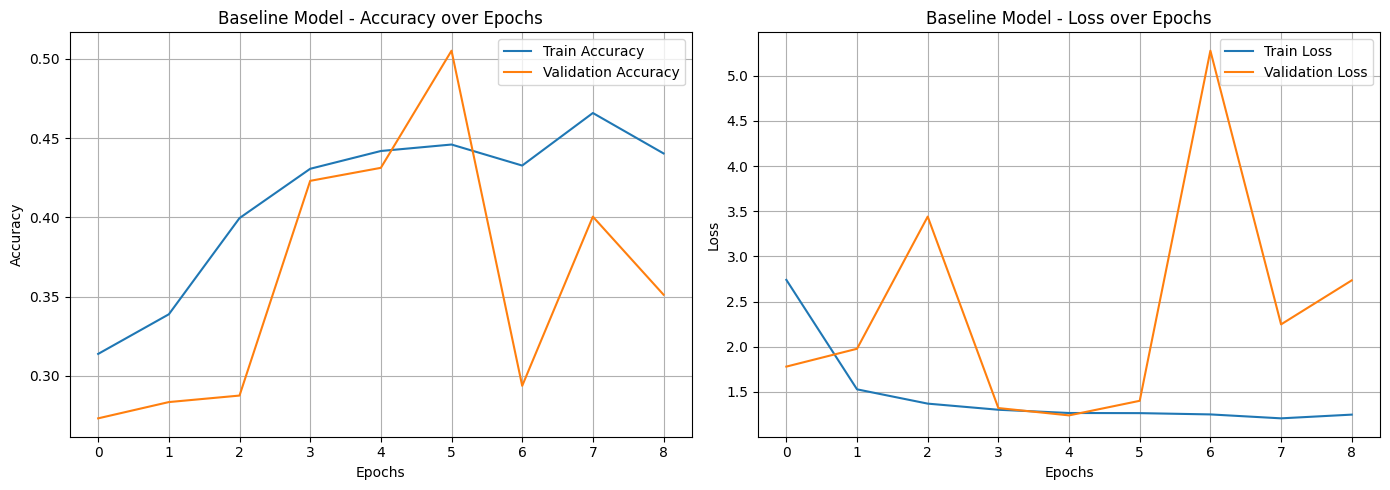

In [29]:
# Call the plot function
plot_baseline_history(history_deeper_adam)

621/621 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

📋 Classification Report - Deeper CNN (Adam):
                  precision    recall  f1-score   support

    glioma_tumor       0.36      0.94      0.52       181
meningioma_tumor       0.34      0.06      0.10       183
          normal       0.50      0.01      0.02        88
 pituitary_tumor       0.68      0.46      0.55       169

        accuracy                           0.42       621
       macro avg       0.47      0.37      0.30       621
    weighted avg       0.46      0.42      0.34       621



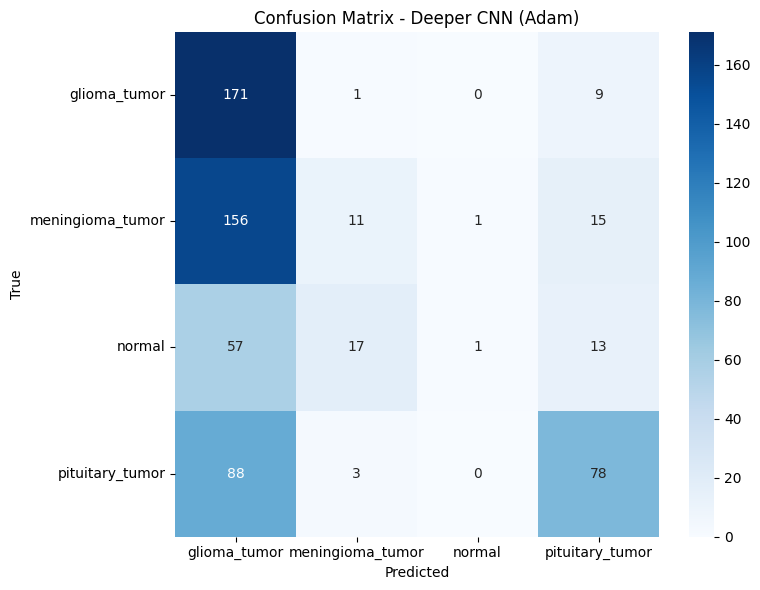

In [30]:
evaluate_model_on_test(deeper_model_adam,test_generator, model_name='Deeper CNN (Adam)')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step

 Model        : Deeper CNN
 Real class   : meningioma_tumor
 Predicted    : glioma_tumor
Prediction probabilities:
  glioma_tumor: 0.7052
  meningioma_tumor: 0.1878
  normal: 0.0467
  pituitary_tumor: 0.0602


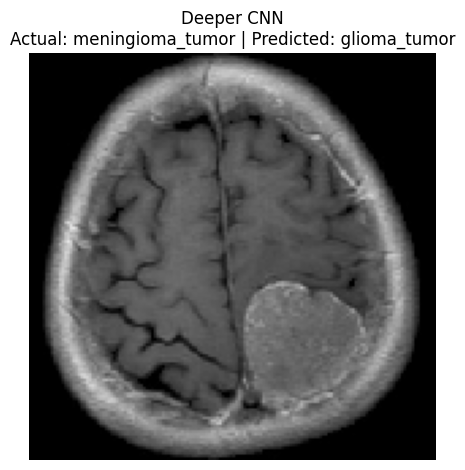

In [31]:
predict_and_display_image_for_model(
    model=deeper_model_adam,
    model_name='Deeper CNN',
    target_size=(150,150)
)


## Experimentation and Comparative Analysis

##  Comparative Visualization

* Base VS Deeper CNN

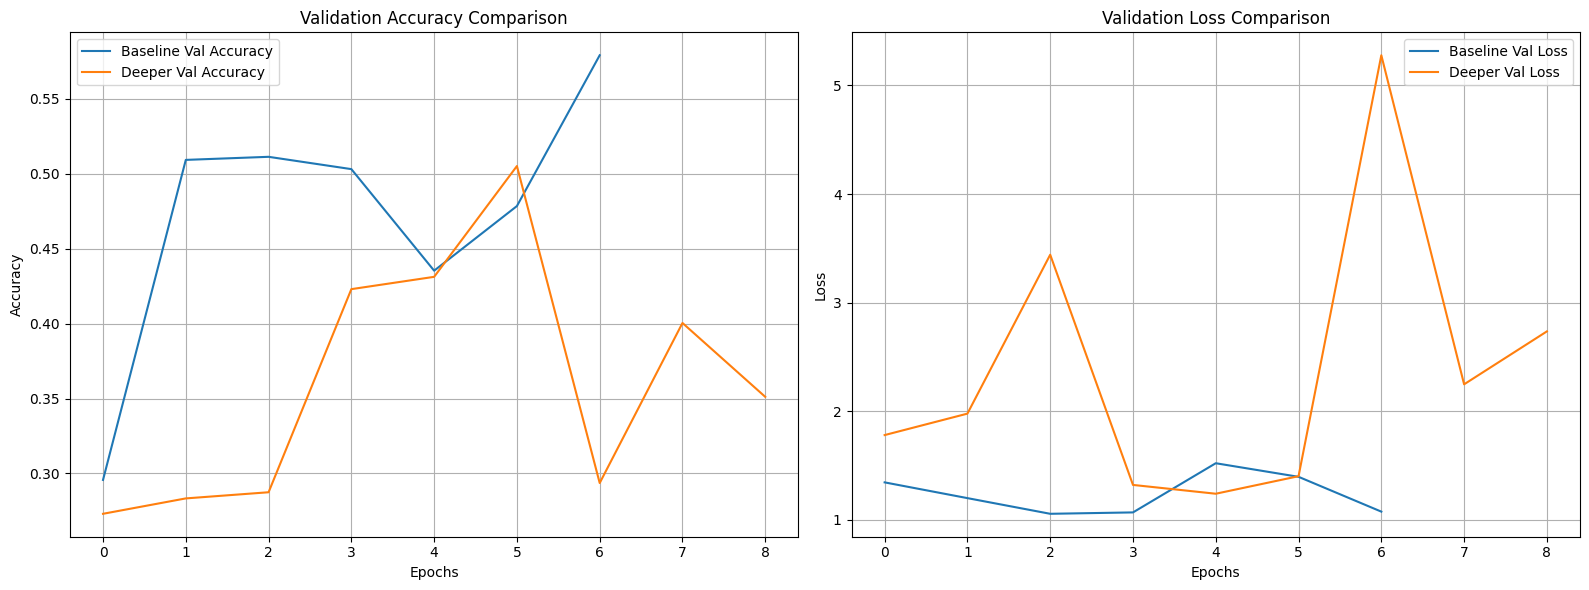

In [32]:
import matplotlib.pyplot as plt

def plot_history(histories, labels):
    plt.figure(figsize=(16, 6))

    #  Validation Accuracy
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=f'{label} Val Accuracy')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    #  Validation Loss
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_loss'], label=f'{label} Val Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot results
plot_history([history_baseline, history_deeper_adam], ['Baseline', 'Deeper'])


In [33]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

# Build and compile deeper model with SGD
deeper_model_sgd = build_deeper_model((150,150, 3), train_generator.num_classes)
deeper_model_sgd.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:

#  Callbacks for SGD
checkpoint_sgd = ModelCheckpoint('deeper_sgd_best.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stop_sgd = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)

#  Start timing
start_sgd = time.time()

#  Train with SGD
history_deeper_sgd = deeper_model_sgd.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint_sgd, early_stop_sgd]
)

#  End timing
end_sgd = time.time()
print(f" Deeper model (SGD) training time: {(end_sgd - start_sgd)/60:.2f} minutes")


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.3193 - loss: 2.7256
Epoch 1: val_loss improved from inf to 1.84049, saving model to deeper_sgd_best.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.3196 - loss: 2.7158 - val_accuracy: 0.1437 - val_loss: 1.8405
Epoch 2/50
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.3282 - loss: 1.3856
Epoch 2: val_loss improved from 1.84049 to 1.23218, saving model to deeper_sgd_best.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 0.3282 - loss: 1.3850 - val_accuracy: 0.4867 - val_loss: 1.2322
Epoch 3/50
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.3742 - loss: 1.3229
Epoch 3: val_loss did not improve from 1.23218
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - accuracy: 0.3738 - loss: 1.3235 - val_accuracy: 0.3984 - val_loss: 1.2549
Epoch 4/50
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.3707 - loss: 1.2802
Epoch 4: val_loss did not improve from 1.23218
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 1

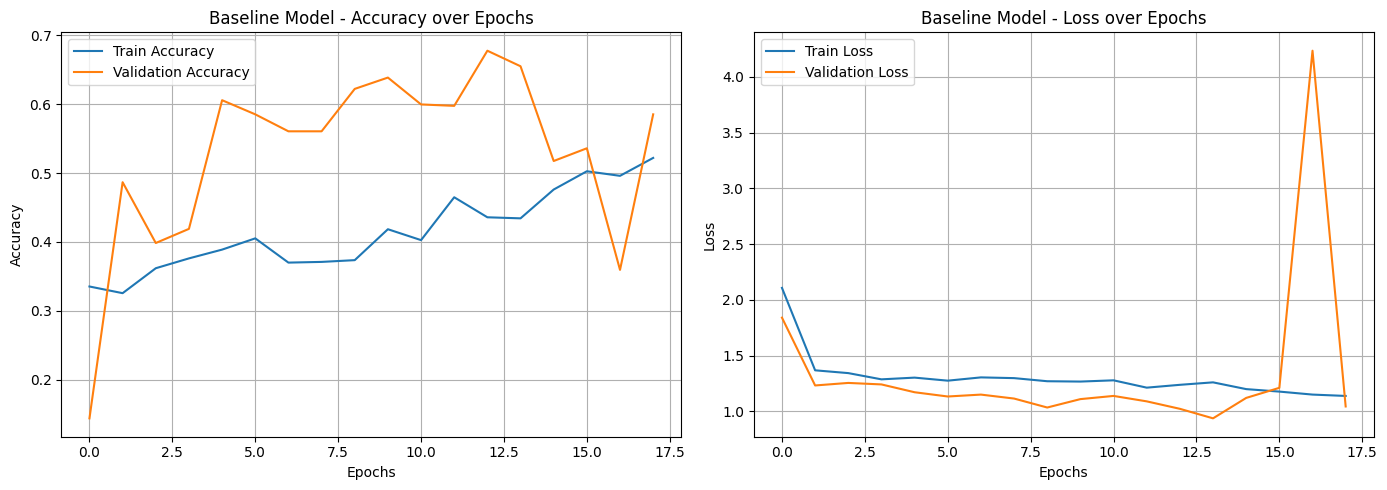

In [35]:
# Call the plot function
plot_baseline_history(history_deeper_sgd)

621/621 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

📋 Classification Report - Deeper CNN with SGD:
                  precision    recall  f1-score   support

    glioma_tumor       0.66      0.52      0.59       181
meningioma_tumor       0.47      0.72      0.57       183
          normal       0.70      0.24      0.36        88
 pituitary_tumor       0.72      0.72      0.72       169

        accuracy                           0.59       621
       macro avg       0.64      0.55      0.56       621
    weighted avg       0.63      0.59      0.58       621



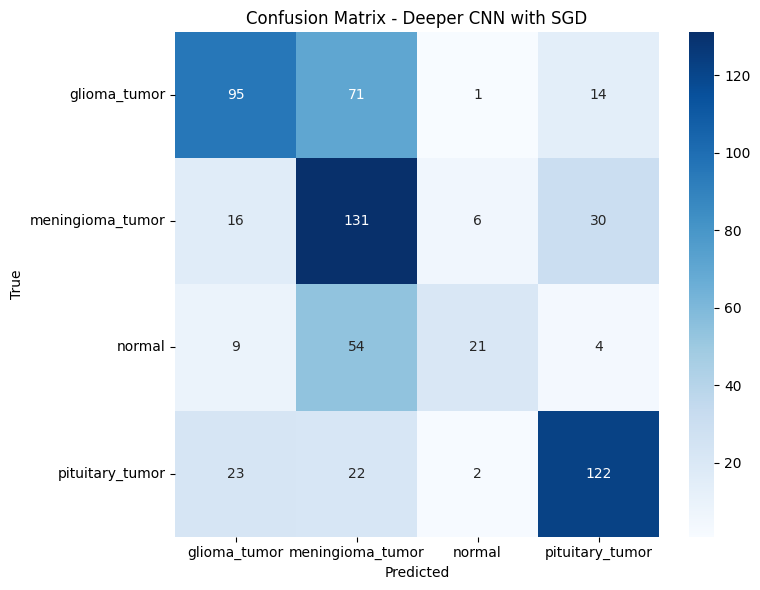

In [36]:
evaluate_model_on_test(deeper_model_sgd, test_generator, model_name='Deeper CNN with SGD')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step

 Model        : Deeper CNN SGD
 Real class   : meningioma_tumor
 Predicted    : meningioma_tumor
Prediction probabilities:
  glioma_tumor: 0.2991
  meningioma_tumor: 0.3466
  normal: 0.1065
  pituitary_tumor: 0.2478


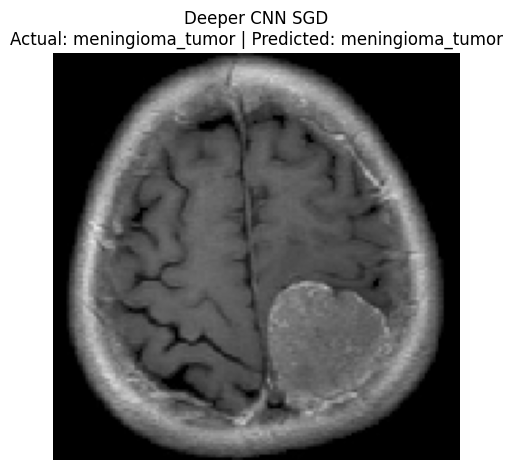

In [37]:
predict_and_display_image_for_model(
    model=deeper_model_sgd,
    model_name='Deeper CNN SGD',
    target_size=(150,150)
)

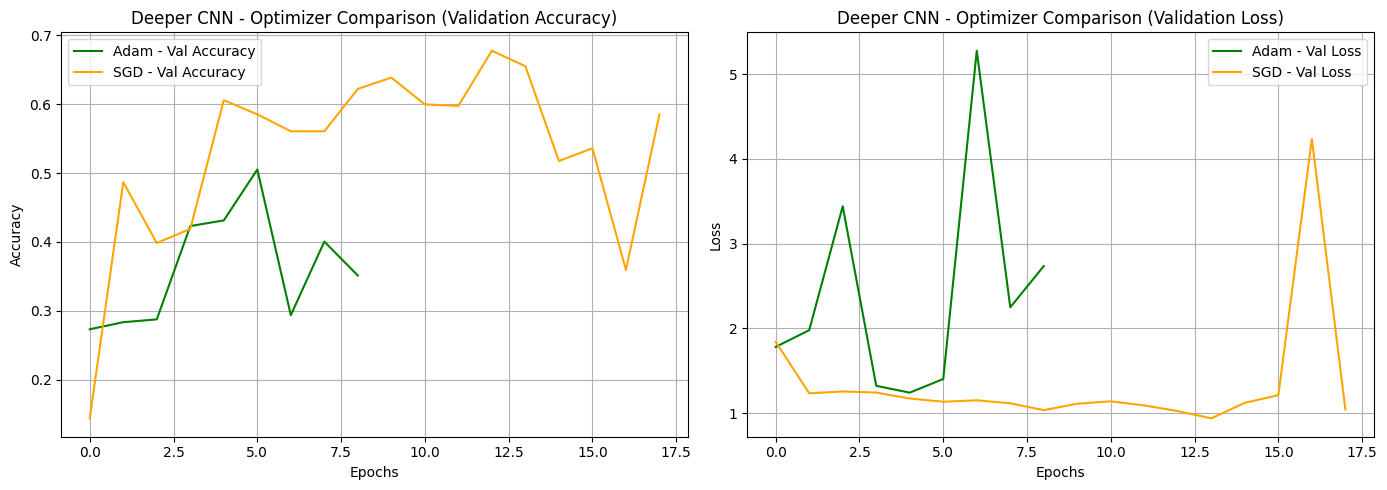

In [38]:
import matplotlib.pyplot as plt

def compare_optimizers(history_adam, history_sgd, label='Deeper CNN'):
    plt.figure(figsize=(14, 5))

    # Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_adam.history['val_accuracy'], label='Adam - Val Accuracy', color='green')
    plt.plot(history_sgd.history['val_accuracy'], label='SGD - Val Accuracy', color='orange')
    plt.title(f'{label} - Optimizer Comparison (Validation Accuracy)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_adam.history['val_loss'], label='Adam - Val Loss', color='green')
    plt.plot(history_sgd.history['val_loss'], label='SGD - Val Loss', color='orange')
    plt.title(f'{label} - Optimizer Comparison (Validation Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#  Call the comparison plot
compare_optimizers(history_deeper_adam, history_deeper_sgd)


##  Transfer Learning with VGG16

In [39]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

#  Set image size to match VGG16 expected input
img_size = (224, 224)  # Updated from 150x150
batch_size = 32

# Update ImageDataGenerators for new size
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 1960 images belonging to 4 classes.
Found 487 images belonging to 4 classes.


In [ ]:

#  Load pre-trained VGG16 and build custom model
def build_vgg16_model_offline(input_shape, num_classes):
    base_model = VGG16(
        weights='/kaggle/input/vgg-model/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False,
        input_shape=input_shape
    )

    for layer in base_model.layers:
        layer.trainable = False  # Feature extraction

    x = layers.Flatten()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [41]:
#  Build and show summary for feature extraction phase
vgg_model = build_vgg16_model_offline((224, 224, 3), train_generator.num_classes)
print(" VGG16 Model Summary (Before Fine-Tuning):")
vgg_model.summary()

 VGG16 Model Summary (Before Fine-Tuning):


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [42]:
# Callbacks
early_stop_vgg = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
checkpoint_vgg = ModelCheckpoint('VGG_best.keras', monitor='val_loss', save_best_only=True, verbose=1)

#  Initial training (feature extraction only)
vgg_model = build_vgg16_model_offline((224, 224, 3), train_generator.num_classes)
history_vgg = vgg_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop_vgg, checkpoint_vgg]
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.3260 - loss: 3.1719
Epoch 1: val_loss improved from inf to 1.02301, saving model to VGG_best.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 55s 563ms/step - accuracy: 0.3269 - loss: 3.1521 - val_accuracy: 0.4825 - val_loss: 1.0230
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.4626 - loss: 1.1539
Epoch 2: val_loss improved from 1.02301 to 0.85496, saving model to VGG_best.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 390ms/step - accuracy: 0.4630 - loss: 1.1532 - val_accuracy: 0.6550 - val_loss: 0.8550
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.5069 - loss: 1.0615
Epoch 3: val_loss improved from 0.85496 to 0.76427, saving model to VGG_best.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 384ms/step - accuracy: 0.5071 - loss: 1.0612 - val_accuracy: 0.6776 - val_loss: 0.7643
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.5715 - loss: 0.9689
Epoch 4: val_loss improved from 0.76427 to 0.71757, saving model to 

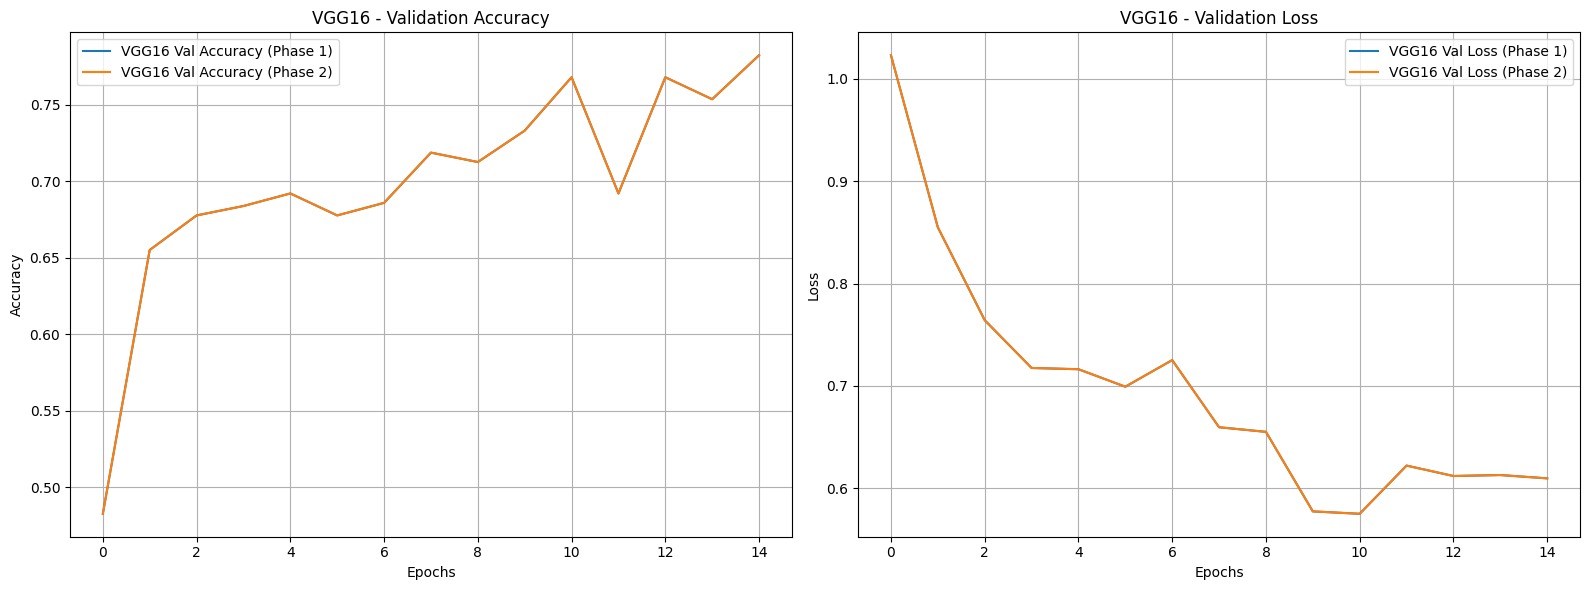

In [43]:
import matplotlib.pyplot as plt

def plot_vgg_histories(history1, history2, label='VGG16'):
    plt.figure(figsize=(16, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['val_accuracy'], label=f'{label} Val Accuracy (Phase 1)')
    plt.plot(history2.history['val_accuracy'], label=f'{label} Val Accuracy (Phase 2)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{label} - Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['val_loss'], label=f'{label} Val Loss (Phase 1)')
    plt.plot(history2.history['val_loss'], label=f'{label} Val Loss (Phase 2)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{label} - Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#  Plot both phases
plot_vgg_histories(history_vgg, history_vgg)

621/621 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.85      0.75      0.79       181
meningioma_tumor       0.68      0.59      0.63       183
          normal       0.88      0.72      0.79        88
 pituitary_tumor       0.71      0.96      0.82       169

        accuracy                           0.76       621
       macro avg       0.78      0.75      0.76       621
    weighted avg       0.76      0.76      0.75       621



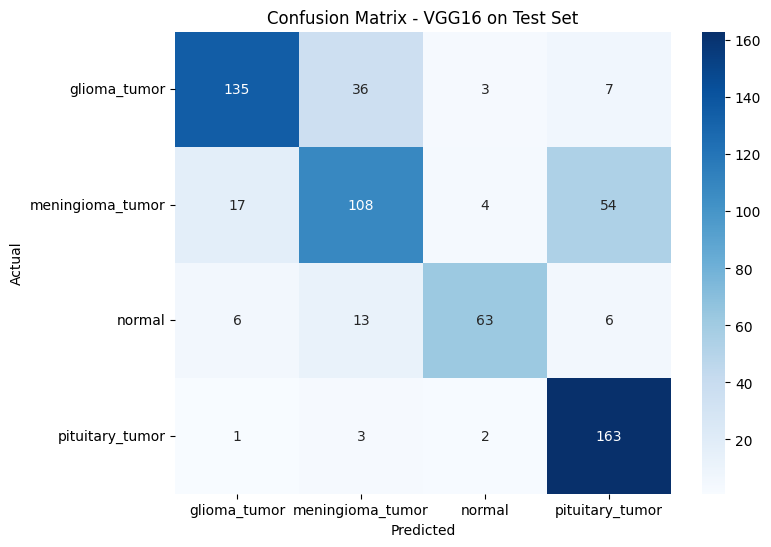

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns


# Get predictions
pred_probs = vgg_model.predict(test_generator_224, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator_224.classes
class_labels = list(test_generator_224.class_indices.keys())

#  Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

#  Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - VGG16 on Test Set")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step

 Model        : VGG Model
 Real class   : meningioma_tumor
 Predicted    : meningioma_tumor
Prediction probabilities:
  glioma_tumor: 0.2378
  meningioma_tumor: 0.6105
  normal: 0.0295
  pituitary_tumor: 0.1222


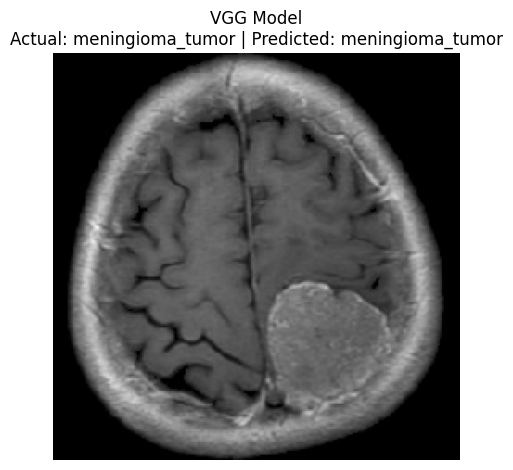

In [45]:
predict_and_display_image_for_model(
    model=vgg_model,
    model_name='VGG Model',
    target_size=(224,224)
)

In [ ]:
#  Fine-tuning 
for layer in vgg_model.layers[-8:]:  # Adjust to unfreeze part of the base model
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

vgg_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 13,503,236 (51.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [47]:

# Continue training (fine-tuning)
history_vgg_finetune = vgg_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop_vgg, checkpoint_vgg]
)


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.6605 - loss: 0.7469
Epoch 1: val_loss improved from 0.57514 to 0.53499, saving model to VGG_best.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 434ms/step - accuracy: 0.6606 - loss: 0.7467 - val_accuracy: 0.7762 - val_loss: 0.5350
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.6785 - loss: 0.7442
Epoch 2: val_loss improved from 0.53499 to 0.50902, saving model to VGG_best.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 389ms/step - accuracy: 0.6784 - loss: 0.7444 - val_accuracy: 0.7864 - val_loss: 0.5090
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.6583 - loss: 0.7192
Epoch 3: val_loss improved from 0.50902 to 0.46294, saving model to VGG_best.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 393ms/step - accuracy: 0.6585 - loss: 0.7191 - val_accuracy: 0.8131 - val_loss: 0.4629
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.6695 - loss: 0.7601
Epoch 4: val_loss did not improve from 0.46294
62/62 

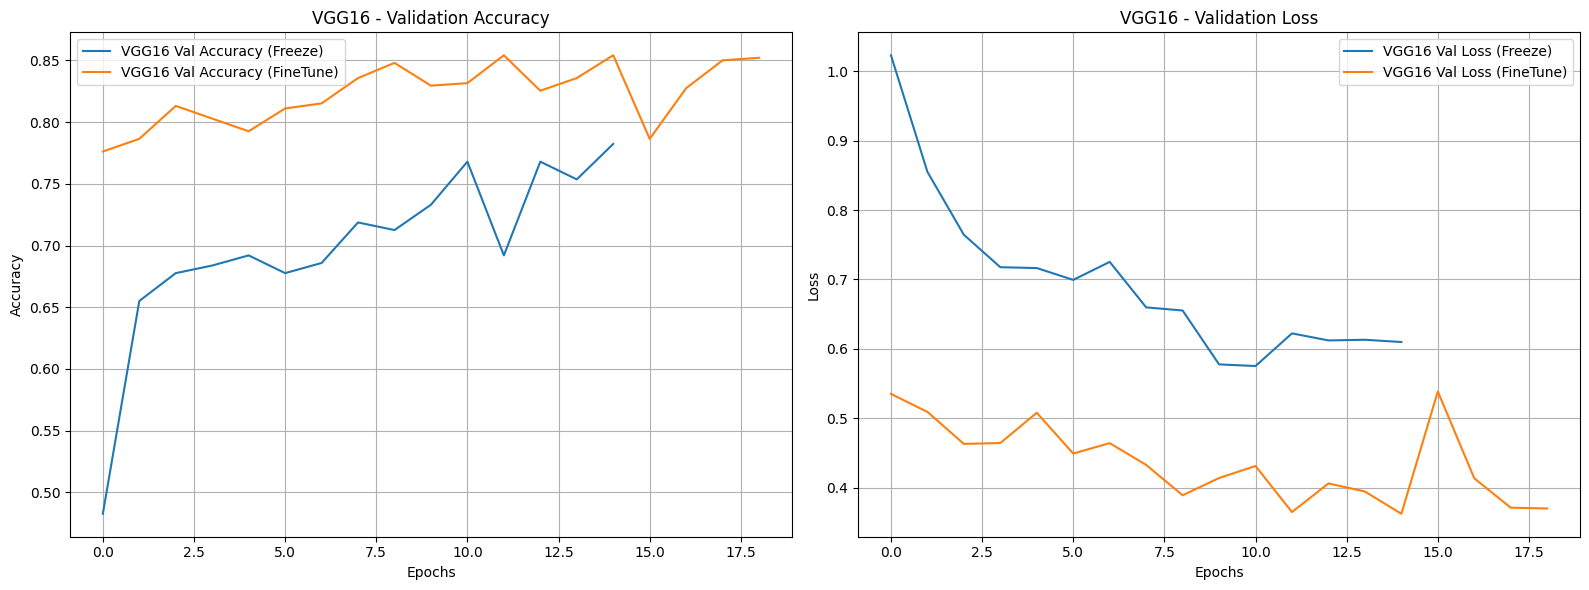

In [ ]:
import matplotlib.pyplot as plt

def plot_vgg_histories(history1, history2=None, label='VGG16'):
    plt.figure(figsize=(16, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label=f'{label} Train Accuracy (Phase 1)')
    plt.plot(history1.history['val_accuracy'], label=f'{label} Val Accuracy (Phase 1)')
    if history2:
        plt.plot(history2.history['accuracy'], label=f'{label} Train Accuracy (Phase 2)')
        plt.plot(history2.history['val_accuracy'], label=f'{label} Val Accuracy (Phase 2)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{label} - Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label=f'{label} Train Loss (Phase 1)')
    plt.plot(history1.history['val_loss'], label=f'{label} Val Loss (Phase 1)')
    if history2:
        plt.plot(history2.history['loss'], label=f'{label} Train Loss (Phase 2)')
        plt.plot(history2.history['val_loss'], label=f'{label} Val Loss (Phase 2)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{label} - Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


#  Plot both phases
plot_vgg_histories(history_vgg, history_vgg_finetune)


621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.89      0.85      0.87       181
meningioma_tumor       0.82      0.79      0.80       183
          normal       0.89      0.89      0.89        88
 pituitary_tumor       0.88      0.96      0.92       169

        accuracy                           0.87       621
       macro avg       0.87      0.87      0.87       621
    weighted avg       0.87      0.87      0.87       621



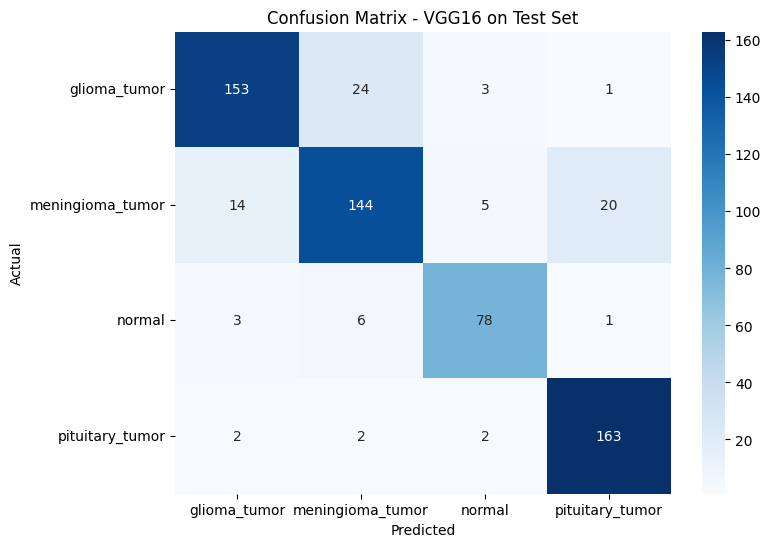

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns


# Get predictions
pred_probs = vgg_model.predict(test_generator_224, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator_224.classes
class_labels = list(test_generator_224.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - VGG16 on Test Set")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step

 Model        : VGG Model
 Real class   : meningioma_tumor
 Predicted    : meningioma_tumor
Prediction probabilities:
  glioma_tumor: 0.1703
  meningioma_tumor: 0.7094
  normal: 0.0012
  pituitary_tumor: 0.1191


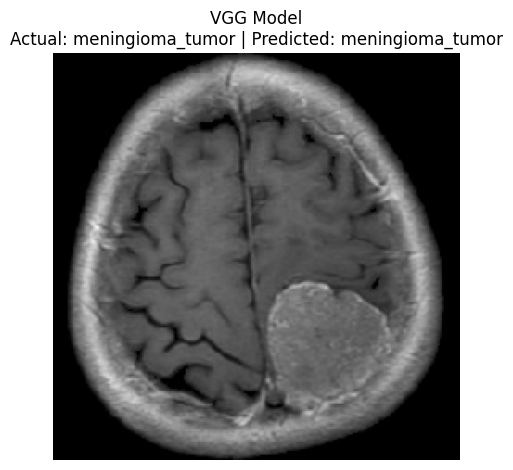

In [50]:
predict_and_display_image_for_model(
    model=vgg_model,
    model_name='VGG Model',
    target_size=(224,224)
)

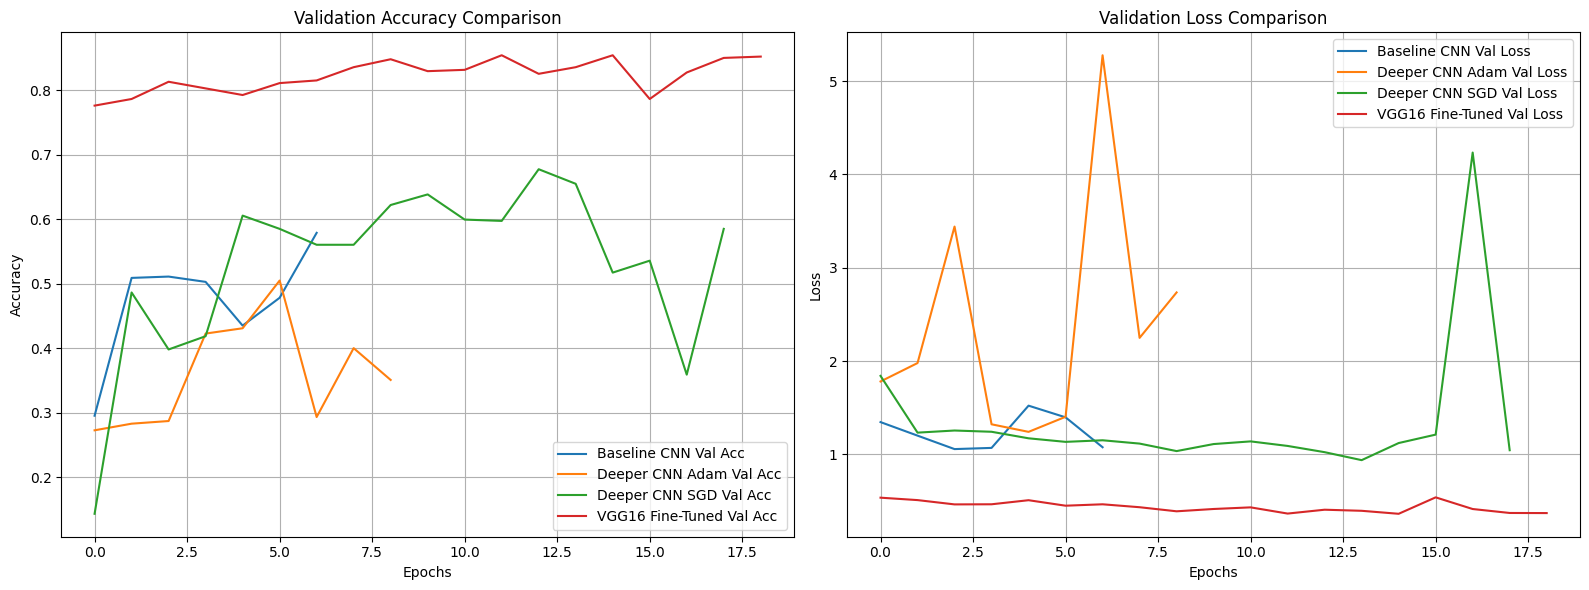

In [51]:
def plot_all_model_histories(histories, labels):
    plt.figure(figsize=(16, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=f'{label} Val Acc')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_loss'], label=f'{label} Val Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#  Compare all models (merge vgg fine-tuning history into one)
plot_all_model_histories(
    [history_baseline, history_deeper_adam,history_deeper_sgd, history_vgg_finetune],
    ['Baseline CNN', 'Deeper CNN Adam','Deeper CNN SGD', 'VGG16 Fine-Tuned']
)
